In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
batch_size = 32

# Transformations
transform = transforms.ToTensor()

# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Encoder Details

* Batch size $B$; latent size $d=\texttt{latent\_dim}$.
* Input $x \in \mathbb{R}^{B\times 1\times 28\times 28}$.
* $x \mapsto (\mu,\log\sigma^2)$
* $
(\mu,\ \ell)\;=\;\text{encoder}(x),
\quad \ell=\log\sigma^2
$ : interpreted as parameters of a diagonal Gaussian approximate posterior: $
 q_\phi(z\mid x)=\mathcal{N}\!\big(\mu(x),\ \mathrm{diag}(\sigma^2(x))\big),
 \quad \sigma(x)=\exp\!\big(\tfrac{1}{2}\ell(x)\big).
$
* Shapes: $\mu, \ell \in \mathbb{R}^{B\times d}$.


* Input MNIST image: $ x \in \mathbb{R}^{1 \times 28 \times 28} $

$$
(B,1,28,28)\;\xrightarrow{\textbf{Conv+ReLU}}\;
(B,16,14,14)\;\xrightarrow{\textbf{Conv+ReLU}}\;
(B,32,7,7)\;\xrightarrow{\textbf{Flatten}}\;
(B,1568)\;\xrightarrow{\textbf{FC+ReLU}}\;
(B,128)\;\xrightarrow{\textbf{Heads}}\;
\mu\!\in\!\mathbb{R}^{B\times d},\ \log\sigma^2\!\in\!\mathbb{R}^{B\times d}.
$$


In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        h = self.conv_layers(x)
        h = F.relu(self.fc1(h))
        return self.fc_mu(h), self.fc_logvar(h)

## Decoder Details
$$ 
(B,d)
\ \xrightarrow{\text{Linear+ReLU}}\ 
(B,128)
\ \xrightarrow{\text{Linear+ReLU}}\ 
(B,1568)
\ \xrightarrow{\text{Unflatten}}\ 
(B,32,7,7)
\ \xrightarrow{\text{ConvT(3, s=2, p=1, opad=1)+ReLU}}\ 
(B,16,14,14)
\ \xrightarrow{\text{ConvT(3, s=2, p=1, opad=1)+Sigmoid}}\ 
(B,1,28,28).
$$


In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7))
        )
        self.convtranspose_layers = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        h = self.fc(z)
        return self.convtranspose_layers(h)
     

Math (elementwise):

$
\sigma = \exp\!\big(\tfrac{1}{2}\ell\big), \qquad
\varepsilon \sim \mathcal{N}(0,I_d), \qquad
z \;=\; \mu \;+\; \sigma \odot \varepsilon.
$

* Distribution: given $x$, $z\mid x \sim \mathcal{N}\!\big(\mu,\ \mathrm{diag}(\sigma^2)\big)$ as desired.
* Why this trick works: it converts stochastic sampling into a deterministic function of $\varepsilon$ (noise independent of $\mu,\sigma$), enabling gradients to flow:

  $
  \frac{\partial z}{\partial \mu}=1, \qquad
  \frac{\partial z}{\partial \ell}
  = \frac{\partial}{\partial \ell}\big(\mu+\exp(\tfrac{1}{2}\ell)\odot \varepsilon\big)
  = \tfrac{1}{2}\exp(\tfrac{1}{2}\ell)\odot \varepsilon
  = \tfrac{1}{2}\sigma\odot \varepsilon.
  $
* Shapes: $\sigma,\varepsilon,z \in \mathbb{R}^{B\times d}$.


In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

## Cost Function
**Reconstruction loss (Bernoulli NLL: negative log-likelihood):**

With pixels indexed by $i=1\ldots P$ (e.g., $P=784$) and batch $n=1\ldots B$,

  $
  \text{BCE}
  = -\sum_{n=1}^{B}\sum_{i=1}^{P}
    \Big[x_{ni}\,\log \hat{x}_{ni} + (1-x_{ni})\,\log(1-\hat{x}_{ni})\Big].
  $

  (Assumes $\hat{x}=\text{recon\_x}\in(0,1)$ from a Sigmoid, i.e., Bernoulli likelihood.)

**KL divergence to the standard normal:**

Kullback-Leibler (KL) Divergence, a measure of how one probability distribution diverges from a second, expected probability distribution. This term penalizes the model if the latent variables deviate from a Standard Normal Distribution, thus enforcing a regularized and structured latent space.

  Let $\ell=\text{logvar}$ and $\sigma^2=\exp(\ell)$. Then

  $
  \text{KLD}
  = \frac{1}{2}\sum_{n=1}^{B}\sum_{j=1}^{d}
    \Big(\mu_{nj}^2 + \sigma_{nj}^2 - 1 - \log\sigma_{nj}^2\Big)
  = -\tfrac{1}{2}\sum_{n,j}\big(1+\ell_{nj}-\mu_{nj}^2-\mathrm{e}^{\ell_{nj}}\big),
  $

  which is $\mathrm{KL}\big(q(z|x)=\mathcal{N}(\mu,\mathrm{diag}(\sigma^2))\ \|\ p(z)=\mathcal{N}(0,I)\big)$.

**Total VAE loss (negative ELBO: Evidence Lower BOund):**

  
  $
  \mathcal{L} = \text{BCE} + \text{KLD}
  = -\sum_{n=1}^{B}\text{ELBO}(x_n)
  $

  Minimizing this equals maximizing the ELBO.
  (BCE: reconstruction fidelity and KLD: latent space regularization.)


In [7]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

## Training

Epoch [1/30]  loss/sample: 166.5939
Epoch [2/30]  loss/sample: 124.0413
Epoch [3/30]  loss/sample: 114.0547
Epoch [4/30]  loss/sample: 110.1180
Epoch [5/30]  loss/sample: 108.2667
Epoch [6/30]  loss/sample: 107.0560
Epoch [7/30]  loss/sample: 106.0509
Epoch [8/30]  loss/sample: 105.2997
Epoch [9/30]  loss/sample: 104.7256
Epoch [10/30]  loss/sample: 104.0936
Epoch [11/30]  loss/sample: 103.6875
Epoch [12/30]  loss/sample: 103.3319
Epoch [13/30]  loss/sample: 103.0521
Epoch [14/30]  loss/sample: 102.8222
Epoch [15/30]  loss/sample: 102.5954
Epoch [16/30]  loss/sample: 102.4343
Epoch [17/30]  loss/sample: 102.2245
Epoch [18/30]  loss/sample: 102.0828
Epoch [19/30]  loss/sample: 101.9243
Epoch [20/30]  loss/sample: 101.7941
Epoch [21/30]  loss/sample: 101.6840
Epoch [22/30]  loss/sample: 101.5545
Epoch [23/30]  loss/sample: 101.4228
Epoch [24/30]  loss/sample: 101.3515
Epoch [25/30]  loss/sample: 101.1750
Epoch [26/30]  loss/sample: 101.0934
Epoch [27/30]  loss/sample: 101.0282
Epoch [28/

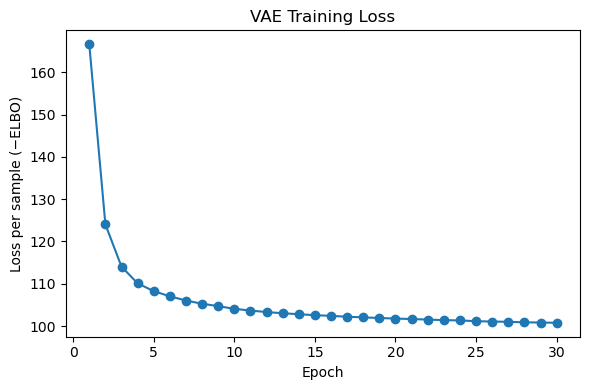

In [10]:
import matplotlib.pyplot as plt
latent_dim = 50
num_epochs = 30
model = VAE(latent_dim)
# model = model.to(device)
model = model.to(device).float()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epoch_losses = []  # loss per sample, per epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    n_samples = 0
    
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = vae_loss(recon_batch, img, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_samples += img.size(0)

    epoch_loss = running_loss / n_samples  # average per sample (−ELBO)
    epoch_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}]  loss/sample: {epoch_loss:.4f}')

# ---- Plot ----
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss per sample (−ELBO)')
plt.title('VAE Training Loss')
plt.tight_layout()
plt.show()

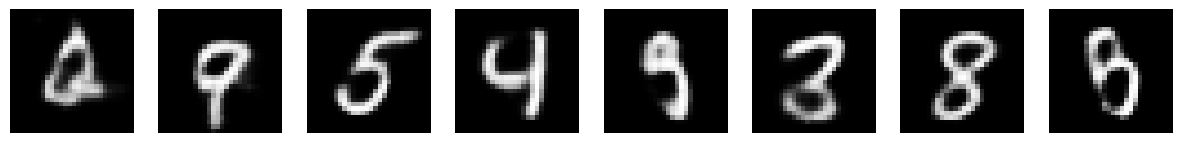

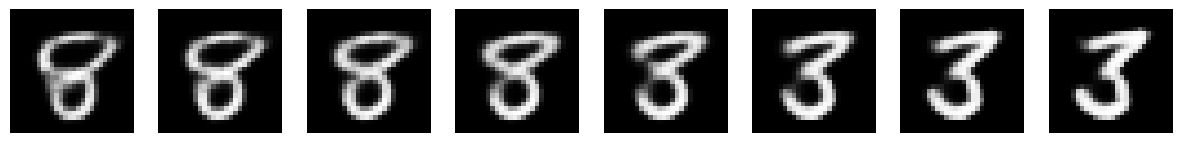

In [12]:
import matplotlib.pyplot as plt

model.eval()

def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space
    z_input = torch.randn(n_samples, latent_dim)
    return z_input

def generate_images(n_samples, model, latent_dim):
    # Sample random points in the latent space
    z_input = generate_latent_points(latent_dim, n_samples)

    # Generate images from these latent points
    model.eval()
    with torch.no_grad():
        # Move the latent vector to the same device as the model
        z_input = z_input.to(next(model.parameters()).device)
        # images = model.decode(z_input)
        images = model.decoder(z_input)

    return images

def interpolate_latent_points(start, end, n_steps=10):
    # Linear interpolation
    ratios = torch.linspace(0, 1, steps=n_steps).unsqueeze(1)
    return start + ratios * (end - start)

def interpolate_and_generate_images(model, latent_dim, n_steps=10):
    # Generate start and end points in the latent space
    start = generate_latent_points(latent_dim, 1)
    end = generate_latent_points(latent_dim, 1)

    # Interpolate between these two points
    interpolated_points = interpolate_latent_points(start, end, n_steps)

    # Generate images
    model.eval()
    with torch.no_grad():
        # Move the latent vector to the same device as the model
        interpolated_points = interpolated_points.to(next(model.parameters()).device)
        images = model.decoder(interpolated_points)

    return images

def show_images(images, n_samples):
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        ax = plt.subplot(1, n_samples, i+1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

# Generate and display images
n_samples = 8  # Number of images to generate
generated_images = generate_images(n_samples, model, latent_dim)
show_images(generated_images, n_samples)

n_steps = 8  # Number of interpolation steps/images
interpolated_images = interpolate_and_generate_images(model, latent_dim, n_steps)
show_images(interpolated_images, n_steps)

**$\beta$-VAE objective:**

$$
\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]\;-\;\beta\,\mathrm{KL}\!\left(q_\phi(z|x)\,\|\,p(z)\right).
$$

**Intuition:** Increasing β makes the encoder “pay more” for using capacity in the latent code. With a stronger bottleneck, it tends to allocate separate latent coordinates to separate, independent generative factors (e.g., shape vs. position vs. scale), yielding a more disentangled latent space.
